# Large margin clasifiers and support vector machines


In [1]:
%pylab inline
import wget
figsize(10, 8)

data_url = "http://empslocal.ex.ac.uk/people/staff/reverson/ECMM422/"

Populating the interactive namespace from numpy and matplotlib


In [37]:
from sklearn import metrics
from cvxopt import matrix
from cvxopt import solvers
solvers.options["show_progress"] = False
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn import datasets

In [38]:
def cv(func, d, t, params, funcSig = []):
    """ Recursively step through a function and its possible parameter iteration """
    if params:
        # iterate through path selection
        data = [ cv(func, d, t, params[1:], funcSig + [var]) for var in params[0]]
        return [list(content) for content in zip(*data)]
    else:
        # end of parameters, evaluate and return
        scores = [func(d[f], t[f], d[vf], t[vf], *funcSig) for f, vf in KFold(n_splits=5, shuffle=True).split(d)]
        mean = sum(scores)/len(scores)
        variance = sum([(x - mean)**2 for x in scores])/len(scores)
        return mean, variance

In [39]:
def digit_data(percentage=0.5, selectedDigit=7):
    # Collect the data from the Sklearn package    
    (X,Y) = datasets.load_digits(return_X_y=True)
    
    # Construct a permutation of the data indexes, evenly split the data into train, test
    permutation = list(range(len(X)))
    random.shuffle(permutation)
    train, test = permutation[:int(len(X)*percentage)], permutation[int(len(X)*percentage):]
    
    Y[Y != selectedDigit], Y[Y == selectedDigit] = -1, 1
    
    # Seperate out the data
    train_data, train_target = X[train], Y[train]
    test_data, test_target = X[test], Y[test]

    # Return the training and test data and targets
    return train_data, train_target, test_data, test_target

In [4]:
def gmm5Data(sampleSize = None):
    
    try: 
        train = loadtxt('gmm5train.txt')
    except IOError:
        wget.download('http://empslocal.ex.ac.uk/~reverson/ECMM422/gmm5train.txt')
        train = loadtxt('gmm5train.txt')

    try: 
        test = loadtxt('gmm5test.txt')
    except IOError:
        wget.download('http://empslocal.ex.ac.uk/~reverson/ECMM422/gmm5test.txt')
        test = loadtxt('gmm5test.txt')
        
    if sampleSize is not None:
        
        indexes = indexes = list(range(1,shape(train)[0]))
        random.shuffle(indexes)
        permutation = indexes[:sampleSize]
        
        return train[permutation,:2], train[permutation,2], test[:,:2], test[:,2]
    
    Xtr, ttr, Xte, tte = train[:,:2], train[:,2], test[:,:2], test[:,2]
    ttr[ttr==0] = -1
    tte[tte==0] = -1
        
    return Xtr, ttr, Xte, tte

In [5]:
def separableData(percentage=0.8, plot_data=False):

    try: 
        separable = loadtxt('separable.txt')
    except IOError:
        wget.download(data_url+"separable.txt")
        separable = loadtxt('separable.txt')

    X = separable[:,:2]
    t = separable[:,2]
    
    if plot_data:
        plot(X[t==-1,0], X[t==-1,1], 'bo')
        plot(X[t==1,0], X[t==1,1], 'rs')
        
    permutation = list(range(len(X)))
    random.shuffle(permutation)
    train, test = permutation[:int(len(X)*percentage)], permutation[int(len(X)*percentage):]

    return X[train], t[train], X[test], t[test]

In [6]:
def unseparableData(percentage=0.8, plot_data=False):
    try: 
        nonseparable = loadtxt('nonseparable.txt')
    except IOError:
        wget.download(data_url+'nonseparable.txt')
        nonseparable = loadtxt('nonseparable.txt')

    X = nonseparable[:,:2]
    t = nonseparable[:,2]

    if plot_data:
        plot(X[t==-1,0], X[t==-1,1], 'bo')
        plot(X[t==1,0], X[t==1,1], 'rs')
    
    permutation = list(range(len(X)))
    random.shuffle(permutation)
    train, test = permutation[:int(len(X)*percentage)], permutation[int(len(X)*percentage):]

    return X[train], t[train], X[test], t[test]

## Constrained optimisation with equality constraints

To begin with we will solve an optimisation problem with equality constraints.  The problem is defined for a two-dimensional $\mathbf{x} = (x_1, x_2)^T$ as follows:
\begin{align*}
    \mbox{min}_\mathbf{x} ~~ f(\mathbf{x}) &= \frac{x_1^2}{2}+ x_2^2\\
    \text{such that}\qquad & x_1 + x_2 = 1
\end{align*}

To see what is going on, make a contour plot of $f(\mathbf{x})$ and draw the contraint line on it.  The following code will draw the contour.  You should add the constraint line. 

You should be able to approximately read the value and location of the contrained minimum from your plot.

//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-1.0, 2.0, -1.0, 2.0)

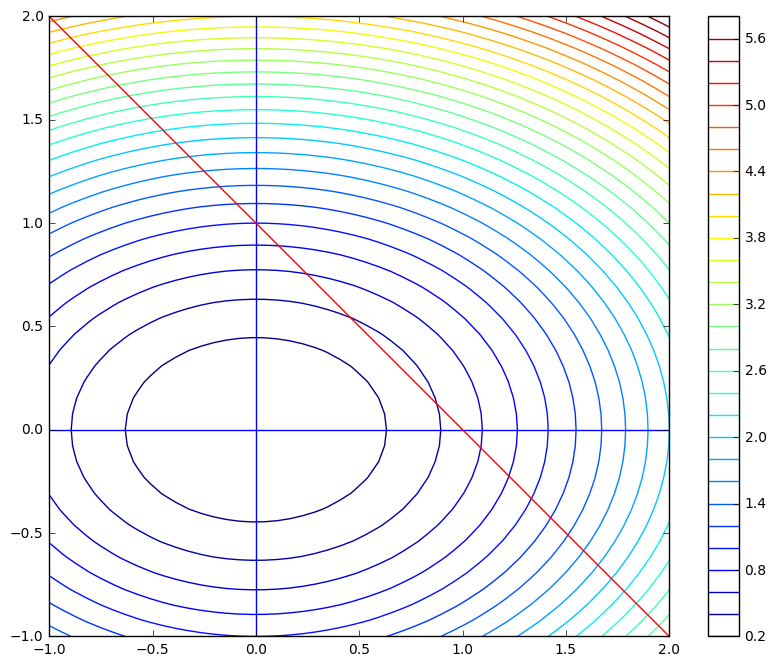

In [7]:
def f(x, y):
    """Evaluate the unconstrained objective function"""
    return x*x/2 + y*y

x = linspace(-1, 2, 50)
y = linspace(-1, 2, 40)
X, Y = meshgrid(x, y)
F = f(X, Y)
axhline(0.0)
axvline(0.0)
#pcolor(X, Y, F, cmap='gray', alpha=0.3)

plot(x, [1- a for a in linspace(-1,2,50) ], "r-", label="Constraint line")

contour(X, Y, F, 30)
colorbar()
axis('scaled')

In [8]:
x = linspace(-1, 2, 50)
y = linspace(-1, 2, 40)
X, Y = meshgrid(x, y)
a = x*y
print(a.shape)
print(X.shape, Y.shape)

ValueError: operands could not be broadcast together with shapes (50,) (40,) 

Write the contraint in standard form $h(\mathbf{x}) = 0$ and therefore write down the Largrangian, $L(\mathbf{x}, \nu)$.  You could do this and the following cells on a piece of paper, but it's not too hard to put it into LaTeX for posterity.

\begin{align*}
h(\mathbf{x}) = x_1 + x_2 - 1 \\
L(x,\nu) = f(x) + \sum_{i=1}^{p}\nu_i h_i({x}) \\
L(x,\nu) = \frac{x_1^2}{2}+ x_2^2 + \sum_{i=1}^{p}\nu_i(x_1 + x_2 - 1)_i \\
\end{align*}


First, minimise the unconstrained minimisation problem by minimising $L(\mathbf{x}, \nu)$ with respect to $\mathbf{x}$ and $\nu$.  This is done by setting the partial derivatives with respect to $x_1$, $x_2$ and $\nu$ to zero and solving for $x_1$, $x_2$ and $\nu$.



##### Unconstaint equation
\begin{align*}
\bigtriangledown f(\mathbf{x}^{\ast}) = \left( \frac{\delta f(\mathbf{x}^{\ast})}{\delta x_1} , \frac{\delta f(\mathbf{x}^{\ast})}{\delta x_2}, \frac{\delta f(\mathbf{x}^{\ast})}{\delta \nu_2}  \right) = 0
\end{align*}

##### Constrained equation
\begin{align*}
\bigtriangledown L(\mathbf{x}, \nu) = \bigtriangledown f(\mathbf{x}) + \nu \bigtriangledown h(\mathbf{x}) \\
\frac{\delta f(\mathbf{x}^{\ast})}{\delta x_1} = (\frac{x_1^2}{2}+ x_2^2 + \nu* (x_1 + x_2 - 1)) \quad \delta x_1 \\
= x_1 + \nu \\
\frac{\delta f(\mathbf{x}^{\ast})}{\delta x_2} = (\frac{x_1^2}{2}+ x_2^2 + \nu* (x_1 + x_2 - 1)) \quad \delta x_2 \\
= 2x_2 + \nu \\ 
\frac{\delta f(\mathbf{x}^{\ast})}{\delta \nu} = (\frac{x_1^2}{2}+ x_2^2 + \nu* (x_1 + x_2 - 1)) \quad \delta \nu \\
= x_1 + x_2 - 1 \\ 
\end{align*}

###### Solving varariables

\begin{align*}
x_1 + x_2 - 1 = 0 \quad \therefore \quad x_1 = 1 - x_2 \\
x_1 + \nu = 0 \quad \to \quad (1 - x_2) + \nu = 0 \quad \therefore \quad x_2 = \nu + 1 \\
2x_2 + \nu = 0 \quad \to \quad 2(\nu + 1) + \nu = 0 \quad \therefore \quad \nu = -\frac{2}{3}\\
x_1 = \frac{2}{3}, \quad x_2 = \frac{1}{3}, \quad \nu = -\frac{2}{3}
\end{align*}

Plot the minimising point on your contour plot and verify that agrees with  the constraint and the function value at the constrained minimum.

(40, 50) (40, 50)


//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-1.0, 2.0, -1.0, 2.0)

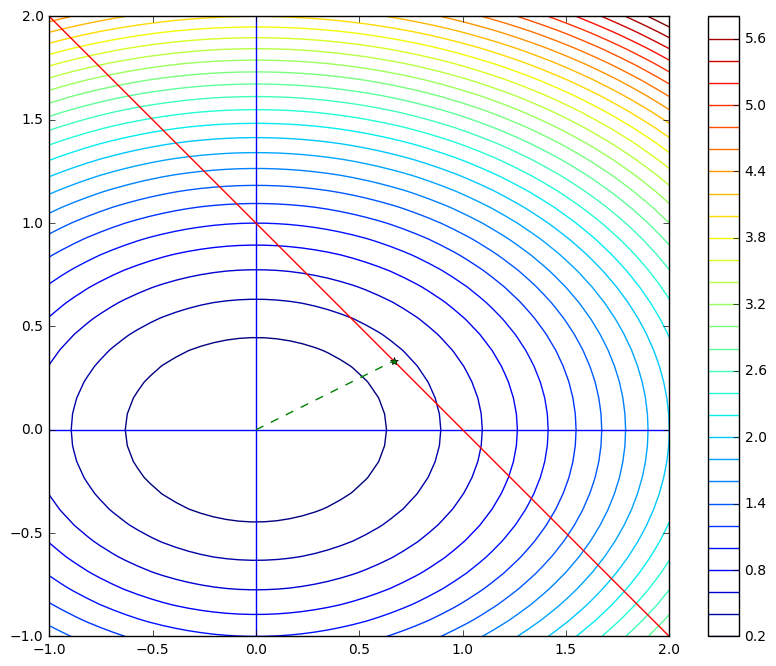

In [66]:
def f(x, y):
    """Evaluate the unconstrained objective function"""
    return x*x/2 + y*y

x = linspace(-1, 2, 50)
y = linspace(-1, 2, 40)
X, Y = meshgrid(x, y)
F = f(X, Y)
axhline(0.0)
axvline(0.0)
#pcolor(X, Y, F, cmap='gray', alpha=0.3)

plot(x, [1- a for a in linspace(-1,2,50) ], "r-", label="Constraint line")
plot([2/3], [1/3], "g*")
plot([0,2/3],[0,1/3],"g--")

contour(X, Y, F, 30)
colorbar()
axis('scaled')

Now we will solve the problem again, but this time by finding the Lagrangian dual function, which we will maximise to find the optimal dual variable $\nu$ and thus the optimal $\mathbf{x}$.

By setting the derivative of the Largrangian with respect to $\mathbf{x}$ to zero, find the Largrangian dual function $g(\nu)$.  

\begin{align*}
 x_1 = -\nu \\
 x_2 = -\frac{\nu}{2}
\end{align*}

\begin{align*}
L(x,\nu) = \frac{x_1^2}{2}+ x_2^2 + \nu_i(x_1 + x_2 - 1)_i \\
L(\nu) = \frac{\nu^2}{2}+ \frac{\nu^2}{4} + \nu(-\nu - \frac{\nu}{2} - 1) \\
L(\nu) = \frac{3\nu^2}{4} + ( - \frac{3\nu^2}{2} - \nu) \\
g(\nu) = -\frac{3\nu^2}{4} - \nu \\
\end{align*}

Maximise $g(\nu)$ with respect to $\nu$ and so find the optimal dual variable $\nu^\star$ and thus $g(\nu^\star)$.

\begin{align*}
g'(\nu) = -\frac{3\nu}{2} - 1 \\
-\frac{3\nu}{2} - 1 = 0 \\
\nu^\star = -\frac{2}{3} \\
\end{align*}

Use the relations you derived when finding the Lagrangian dual function to get $\mathbf{x}^\star$ from $\nu^\star$.  Thus find $f(\mathbf{x}^\star)$ and verify that it equals $g(\nu^\star)$.

\begin{align*}
 x_1 = -\nu \quad \therefore \quad x_1 = \frac{2}{3} \\
 x_2 = -\frac{\nu}{2} \quad \therefore \quad x_2 = \frac{1}{3} \\
\end{align*}

\begin{align*}
f(\mathbf{x^\star}) = \frac{(\frac{2}{3})^2}{2}+ (\frac{1}{3})^2 \\
f(\mathbf{x^\star}) = \frac{1}{3} \\
g(\nu^\star) = -\frac{3(-\frac{2}{3})^2}{4} - (-\frac{2}{3}) \\
g(\nu^\star) = \frac{1}{3}
\end{align*}

## Quadratic programming

At the heart of the dual formulation of the large margin classifier (LMC) is the quadratic programme with constraints.  For example, for the hard LMC the dual Lagrange function to be *maximised* is:
\begin{align*}
          \newcommand{\balpha}{\mathbf{\alpha}}
          \newcommand{\bx}{\mathbf{x}}
        \max_{\balpha} & ~~ \sum_n \alpha_n - \frac{1}{2} \sum_{n,m}t_n t_m
                         \alpha_n\alpha_m \langle\bx_n, \bx_m\rangle\\
        \text{such that   }\quad & \alpha_n \ge 0, \quad \sum_n \alpha_n t_n = 0
\end{align*}
      
There are a number of quadratic progamming functions that you could use, but I recommend that you use those from [cvxopt](http://cvxopt.org/).  On the Blue Room machines you should be able to import the module with:

    import cvxopt
    
If you want to use `cvxopt` on your own machine then you can install it from a shell with `pip`

    pip install cvxopt
    
You may need to install a compiler for this to work.  It should be fine on Linux. On Mac OSX you will need to have `Xcode` installed (free from the App Store and start it up once when you've downloaded it to complete the installation).  

On Windows you may need to work harder, see [Building CVXOPT for Windows](http://cvxopt.org/install/index.html#building-cvxopt-for-windows).   Probably thie easiest thing to do is use the pre-built "wheels version on" [http://www.lfd.uci.edu/~gohlke/pythonlibs/#cvxopt].  You should then be able to install it from the command window with 

    pip install cvxopt-1.1.7-cp34-none-win_amd64.whl

or substitute the appropriate .whl package. An alternative is to use the SciPy `minimize` function; see http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

## `cvxopt` example

Here is an example of solving a constrained quadratic program (QP) with `cvxopt`. This is largely copied from https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

The standard form for a QP in `cvxopt` notation is:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}
where $Gx \preceq h$ means that the inequality is taken element-wise for each row of $Gx$ and $h$.

In `cvxopt` the QP is defined by the parameters $P, q, G, h, A$ and $b$.  The matrix $P$ and the vector $q$ must be specified, but the others are optional.   Note that all optimisations must be manipulated to be of this form.  In particular, note that you will want to *maximise* the Lagrangian dual $g(\mathbf{\alpha})$, so you will have to write the maximisation as the minimisation of $-g(\mathbf{\alpha})$.

Here is a simple example:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^2 + & 3x + 4y\\
        \text{such that   }\quad x, y & \ge 0\\
        x + 3y & \ge 15\\
        2x + 5y & \le 100\\
        3x + 4y & \le 80
\end{align*}


Evaluate the objective function on a grid covering the range $[-5, 20] \times [-5, 20]$ and so plot contours of the objective function.  Augment your plot with lines showing the inequalities and so, by eye, find the minimum of the objective function. 

(If you want to be fancy -- not necessary -- you could use the [fillplots](https://github.com/tkf/fillplots) module to plot the region defined by the inequalities.

//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
//anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-5.0, 25.0, -5.0, 25.0)

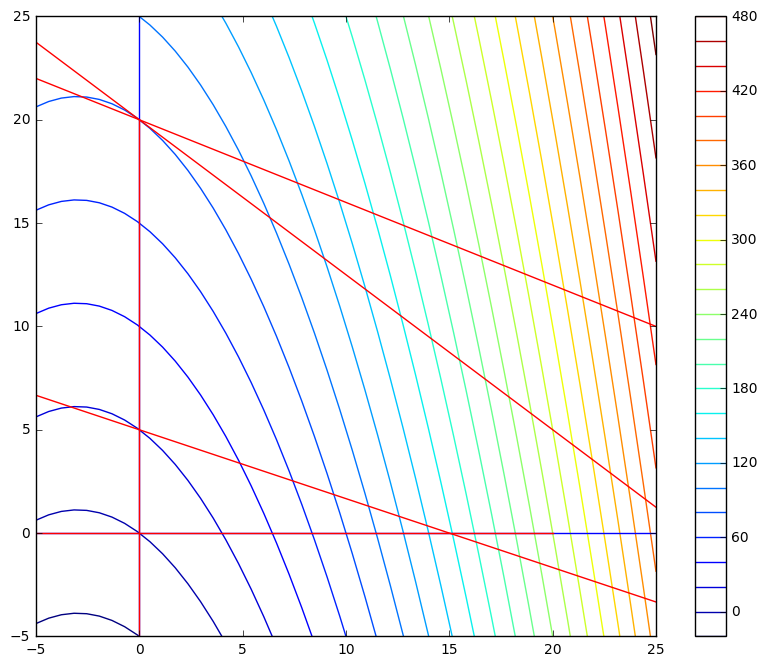

In [10]:
def f(x, y):
    """Evaluate the unconstrained objective function"""
    return 0.5*x**2 + 3*x + 4*y 

x = linspace(-5, 25, 50)
y = linspace(-5, 25, 40)
X, Y = meshgrid(x, y)
F = f(X, Y)



axhline(0.0)
axvline(0.0)
#pcolor(X, Y, F, cmap='gray', alpha=0.3)
contour(X, Y, F, 30)
plot([-5,20], [0,0], "r-")
plot([0,0], [-5,20], "r-")
plot(x, [5-a/3 for a in x], "r-")
plot(x, [20-2*a/5 for a in x], "r-")
plot(x, [20-3*a/4 for a in x], "r-")

ylim(-5,20)
colorbar()
axis('scaled')

The problem can be written in standard form as:

\begin{align*}
  \min_{x, y} \tfrac{1}{2}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}^T
  \begin{bmatrix}
    1 & 0\\
    0 & 0
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}
  +
   \begin{bmatrix}
    3 \\ 4
  \end{bmatrix}^T
 \begin{bmatrix}
    x \\ y
  \end{bmatrix}\\
  \begin{bmatrix}
    -1 & 0\\
    0 & -1\\
    -1 & -3\\
    2 & 5\\
    3 & 4
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}  
  \preceq
  \begin{bmatrix}
    0 \\ 0 \\ -15 \\ 100 \\ 80
  \end{bmatrix}
\end{align*}

Note that all the inequality constraints have been gathered into the matrix $G$ and that since there are no equality constraints $A$ and $b$ do not need to be specified.  Note
that even though $y^2$ did not appear in the original objective, we had to include it with zero coefficients in P because the solver parameters must be defined using the full set of variables.  Even if certain variables only appear in constraints, they will still need to be expressed with zero coefficients in the objective parameters, and *vice versa*.

Matrices specifying the QP to  `cxvopt` are defined using the `cvxopt` matrices.  Since you will be using `numpy` arrays to store the data for your LMC and SVM, we will define the `cvxopt` matrices via `numpy` arrays as follows.  

In [11]:
P = matrix(diag([1,0]), tc='d') 
q = matrix(array([3,4]), tc='d')
G = matrix(array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(array([0,0,-15,100,80]), tc='d')

The `tc='d'` argument ensures that the matrices are floating point numbers rather than integers (`tc` stands for "typcode").

Now, at last, we can solve the QP:

In [12]:

sol = solvers.qp(P, q, G, h)

If there were equality constraints (and don't forget that you will have an equality constraint!) you would get the solution with 

    sol = solvers.qp(P, q, G, h, A, b)

Information about the solution can be found from the `sol` dictionary

In [13]:
print('The solution is\n', sol['x'])
print('The objective is', sol['primal objective'])

The solution is
 [ 7.13e-07]
[ 5.00e+00]

The objective is 20.00000617311241


More information from the various key-value pairs in the dictionary.  See the [`cxvopt` documentation](http://cvxopt.org/userguide/index.html) for more information on what these mean.

In [14]:
for k, v in sol.items():
    print(k, v)

gap 8.788553731701064e-06
relative gap 4.3942774404992717e-07
s [ 7.13e-07]
[ 5.00e+00]
[ 3.74e-06]
[ 7.50e+01]
[ 6.00e+01]

primal infeasibility 1.608116992238204e-16
z [ 1.67e+00]
[ 2.35e-08]
[ 1.33e+00]
[ 1.51e-08]
[ 2.28e-08]

y 
iterations 8
status optimal
primal slack 7.131816408856389e-07
dual objective 19.99999738455868
dual slack 1.506951103604725e-08
x [ 7.13e-07]
[ 5.00e+00]

primal objective 20.00000617311241
dual infeasibility 3.552713678800501e-16


# Hard, large margin classifier

Given a linearly separable training data set `X` and `t`, write a function 

    sv, score = lmc(X, t, Xtest)

to construct a large margin classifier for the data and to classify the data in `Xtest`. 

Your function should construct and solve the Lagrangian dual function for a vector of $\alpha$s.  The the non-zero $\alpha$ correspond the support vectors and your function should return a vector, `sv` of indices of the support vectors in `X` (or a Boolean array indicating the SVs).   Your function should also return a vector, `score`, of the signed distances of each `Xtest` from the optimal hyperplane. The signed distance is the distance from the hyperplane, with the sign specifying which side of the hyperplane the point is on.  It is easily calculated from $\mathbf{w}^T \mathbf{x} + b$.  

Note when classifying an observation $\mathbf{x}$ it is best not to calculate the coefficients $\mathbf{w}$ in order to calculate the discriminant function $\mathbf{w}^T \mathbf{x} + b$.  This is because later, when we use a kernel to map to higher dimensional spaces, $\mathbf{w}$ may be very high dimensional (possibly infinite dimensional).  Instead calculate the discriminant function from the $\mathbf{x}_n, t_n$ and $\alpha_n$.

In [15]:
def graph(Xtr, ttr, Xte = None, tte = None, predicted = None, SV = None, margins=True):
       
    figure()
    plot(Xtr[ttr==1,0], Xtr[ttr==1,1], 'ro', label="Class one")
    plot(Xtr[ttr==-1,0], Xtr[ttr==-1,1], 'bo', label="Class two")

    if SV is not None:
        for x, y, t in SV:
            if t == 1: plot(x, y, 'yo')
            else:      plot(x, y, 'go')
    
        if margins:
            # plot margin lines
            positive, negative = [], []
            [positive.append(sv) for sv in SV if sv[2] == 1]
            [negative.append(sv) for sv in SV if sv[2] == -1]
            #positive, negative = [i for i in SupportVectors if ttr[i] == 1], [i for i in SupportVectors if ttr[i] == -1]
            if len(positive) > len(negative): p1, p2, p3 = positive[0], positive[1], negative[0]
            else:                             p1, p2, p3 = negative[0], negative[1], positive[0]

            gradient = (p1[1] - p2[1])/(p1[0] - p2[0])

            xRange = [min(Xtr[:,0]), max(Xtr[:,0])]

            plot(xRange, [gradient*(x-p1[0]) + p1[1] for x in xRange], "y--", label="Outer margin" )
            plot(xRange, [gradient*(x-p3[0]) + p3[1] for x in xRange], "y--" )
            plot(xRange, [gradient*(x-((p1[0]+p3[0])/2)) + ((p1[1] + p3[1])/2) for x in xRange], "k-", \
                 label="Decision boundary")
            legend()

    if Xte is not None:
        figure()
        plot(Xte[tte==1,0],Xte[tte==1,1],'go')
        plot(Xte[tte==-1,0],Xte[tte==-1,1],'yo')

        if predicted:
            a = sign(predicted)
            plot(Xte[a==1,0],Xte[a==1,1],'g.')
            plot(Xte[a==-1,0],Xte[a==-1,1],'y.')

        if SV and margins:
            xRange = [min(Xte[:,0]), max(Xte[:,0])]

            plot(xRange, [gradient*(x-p1[0]) + p1[1] for x in xRange], "y--", label="Outer margin" )
            plot(xRange, [gradient*(x-p3[0]) + p3[1] for x in xRange], "y--" )
            plot(xRange, [gradient*(x-((p1[0]+p3[0])/2)) + ((p1[1] + p3[1])/2) for x in xRange], "k-", \
                 label="Decision boundary")
            legend()

In [16]:
def lmc(X, t, Xtest, tte = None, C=None):
    N = len(X)

    # Initialise parameters
    P = matrix(outer(t,t) * inner(X,X))
    q = matrix(ones(N) * -1)

    if C is None:
        G = matrix(diag(ones(N) * -1))
        h = matrix(zeros(N))
    else:
        tmp1 = diag(ones(N) * -1)
        tmp2 = identity(N)
        G = matrix(vstack((tmp1, tmp2)))
        tmp1 = zeros(N)
        tmp2 = ones(N) * C
        h = matrix(hstack((tmp1, tmp2)))

    A = matrix(t, (1,N))
    b = matrix(0.0)

    solution = solvers.qp(P, q, G, h, A, b)
    alpha=solution['x']
    
    # Identify the support vector indexes
    SupportVectors = [ i for i,v in enumerate(alpha) if v > 0.00001 ]
    
    # Construct the bias vector
    bias = take(t,SupportVectors)
    for i, svI in enumerate(SupportVectors):
        for j, svJ in enumerate(SupportVectors):
            bias[i] -= alpha[svJ]*t[svJ]*dot(X[svI], X[svJ])
            
    # Calculate the values of Y
    Y = []
    for i, point in enumerate(Xtest):
        Y.append(mean(bias) + sum([alpha[j]*t[j]*dot(X[j], point) for j in SupportVectors]))
    
    return Y, [append(X[i], array([t[i]])) for i in SupportVectors]

Test your code on the following two-dimensional separable data.  Plot the data, the separating hyperplane and its margins, together with the support vectors.

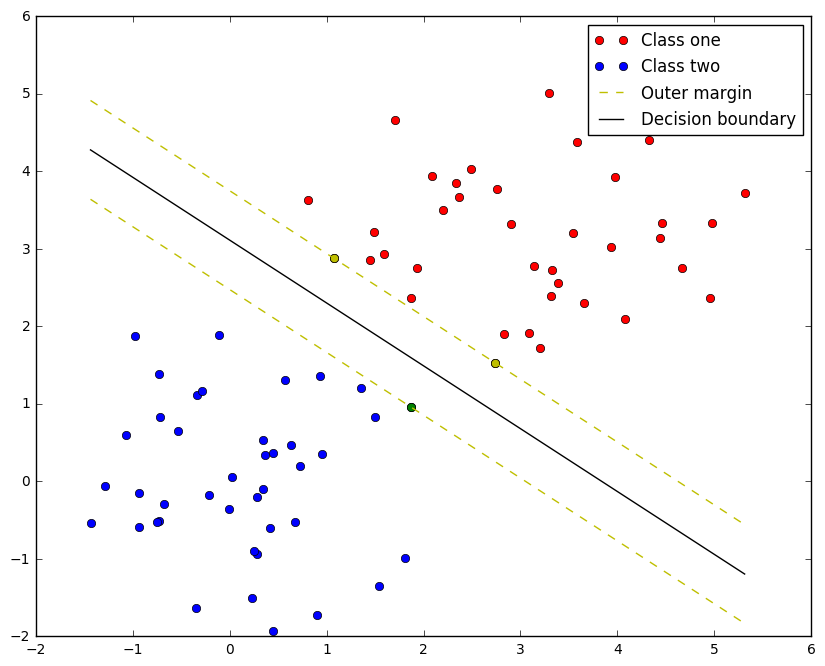

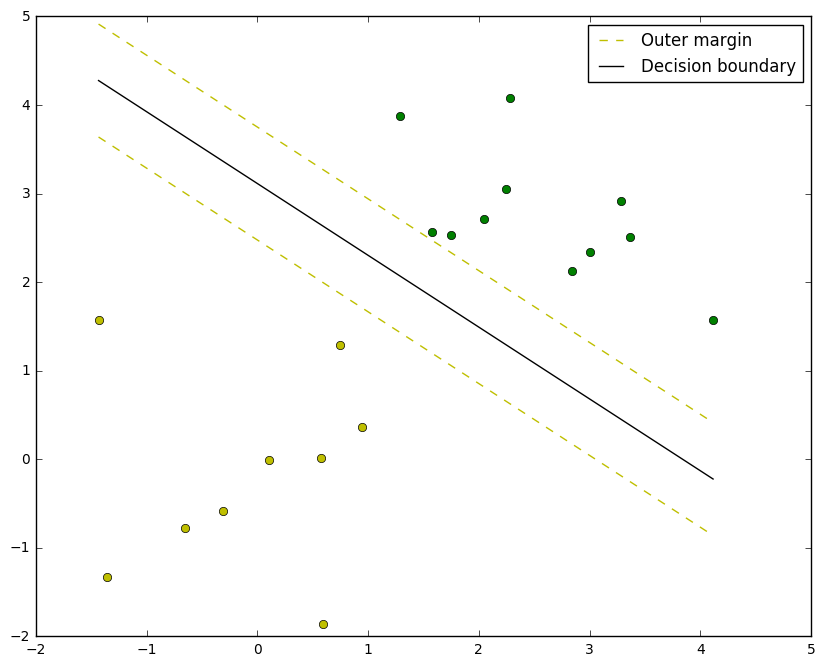

In [17]:
Xtr, ttr, Xte, tte = separableData(percentage=0.8)
a, b = lmc(Xtr, ttr, Xte, tte)
graph(Xtr, ttr, Xte, tte, a, b)

What happens if the data are not separable?  Try it.

Terminated (singular KKT matrix).


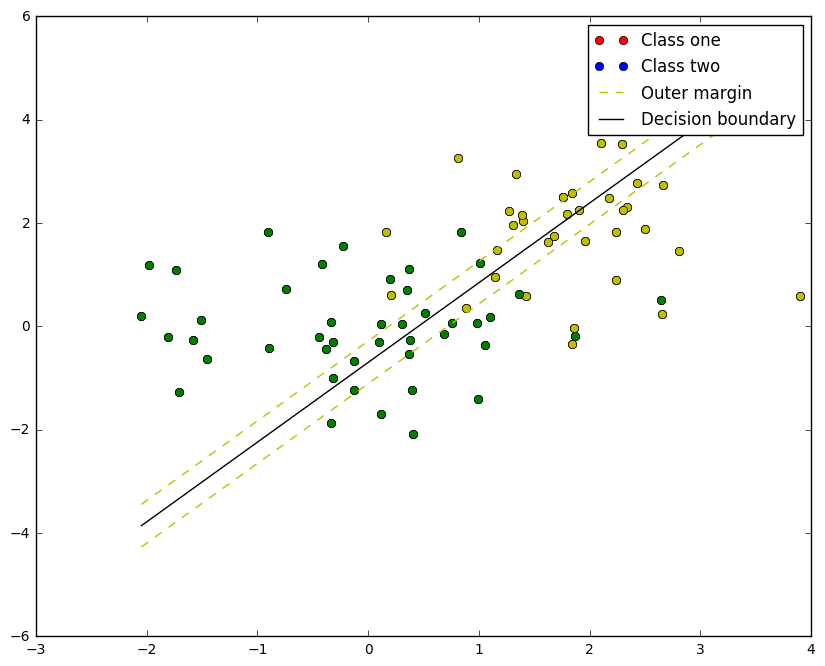

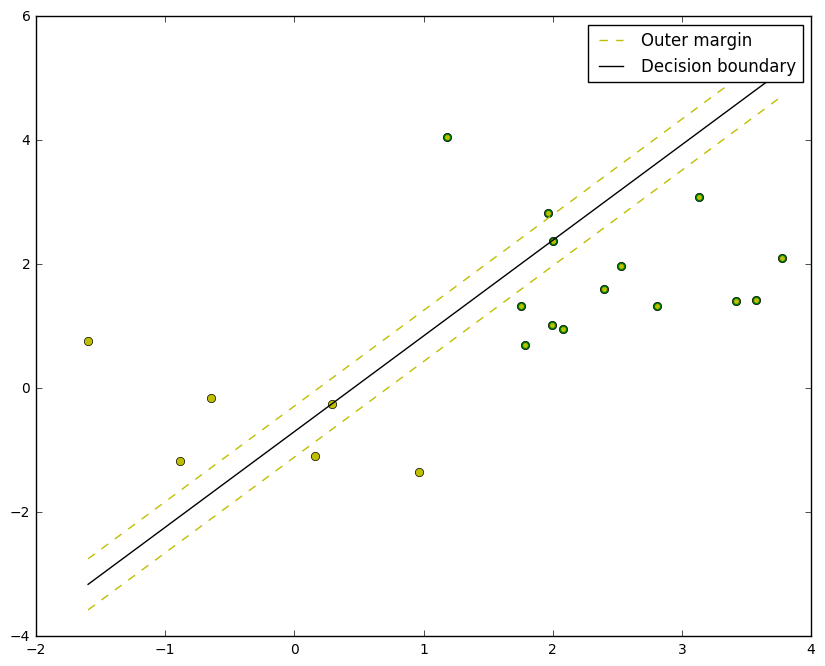

In [19]:
Xtr, ttr, Xte, tte = unseparableData()
Y, sv = lmc(Xtr, ttr, Xte, tte)
graph(Xtr, ttr, Xte, tte, Y, sv)

# Soft, large margin classifier

Of course, most interesting data sets are not linearly separable.  Using your `lmc` function as a basis, write a new function:

    sv, score = lsvm(X, t, C, Xtest)

that implements a soft large margin classifier. The additional parameter `C` should specify the relative weight given to the emperical error versus the regularisation term.

In [20]:
def lsvm(Xtr, ttr, C, Xte, tte = None):
    return lmc(Xtr,ttr,Xte, tte, C)

Test your function on the following simple data set.   These data are drawn from two isotropic Gaussian distributions centred at $(0, 0)$ and $(2, 2)$, so the optimal separating hyperplane, in the limit of a large amount of data, is the perpendicular bisector of the line joining the centres.  As before, plot the separating hyperplane and the support vectors and make a contour plot of the score across the domain.

How does the width of the hyperplane vary with `C`?  

As C is increased, the margin width increases along with the support vectors used to determine the separation.

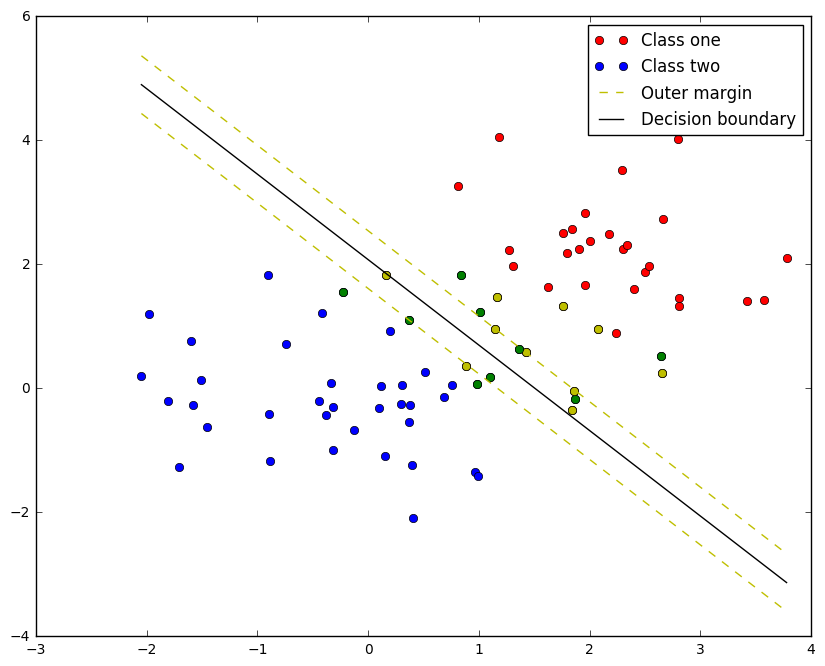

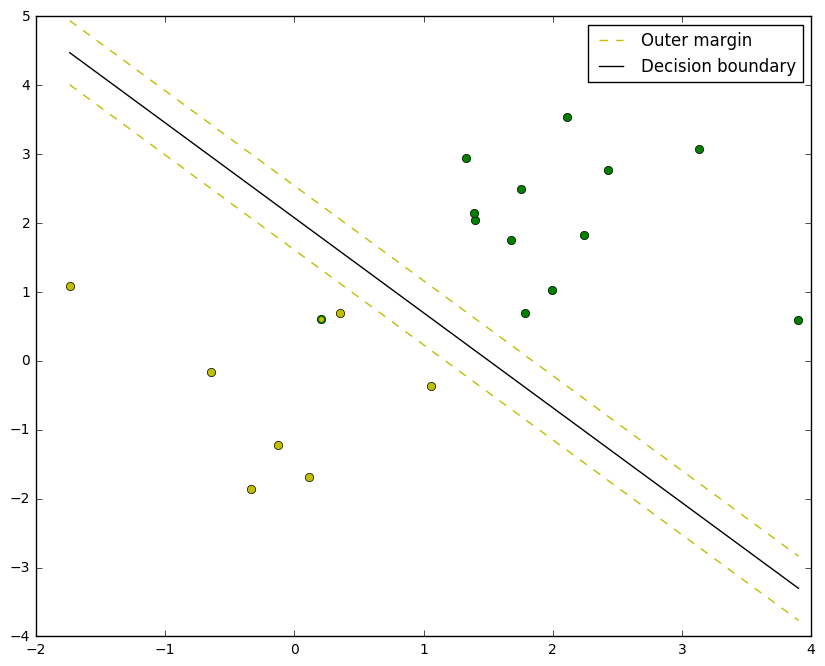

In [23]:
a,b,c,d = unseparableData()
y, sv = lsvm(a,b,10,c,d)
graph(a,b,c,d,y,sv)

Show the performance of your classifier on the `gmm5` data and the digits data that you used in an earlier workshop.

Terminated (singular KKT matrix).


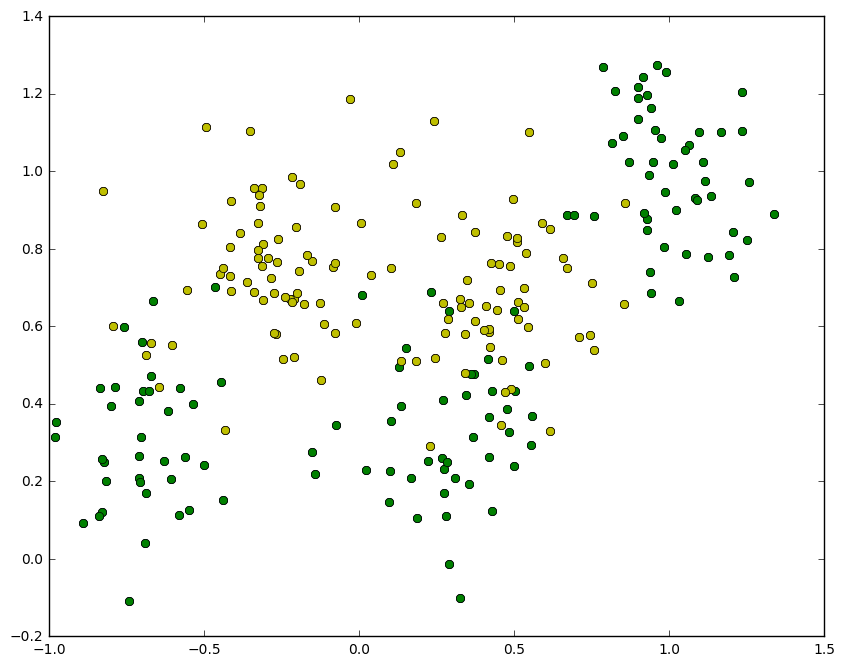

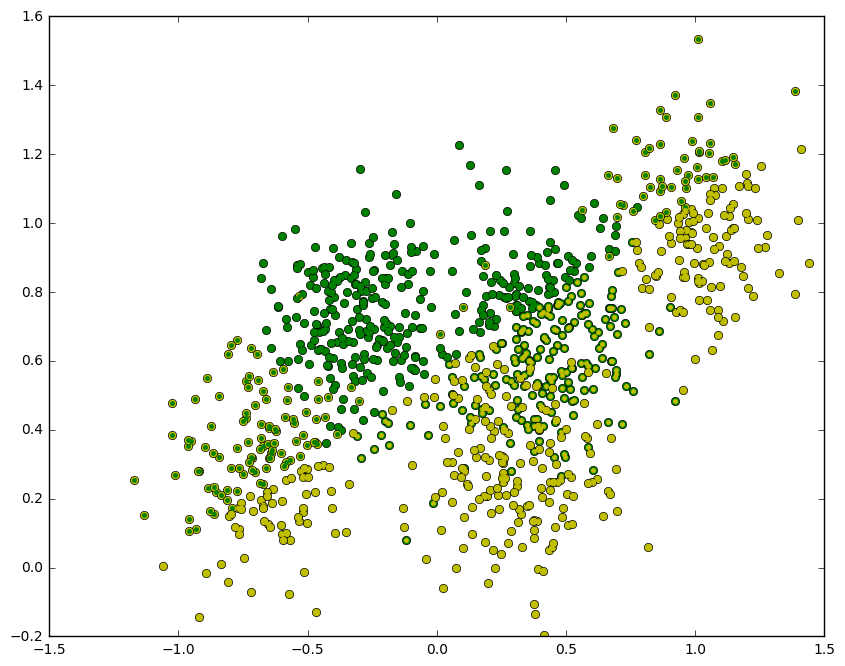

In [27]:
Xtr, ttr, Xte, tte = gmm5Data()
y, sv = lsvm(Xtr,ttr,1000000000,Xte,tte)
graph(Xtr,ttr,Xte,tte,y,sv,margins=False)

# ROC curves

Using the (signed) distance from the separating hyperplane in the SVM as the score, plot the ROC curve for the GMM5 data.


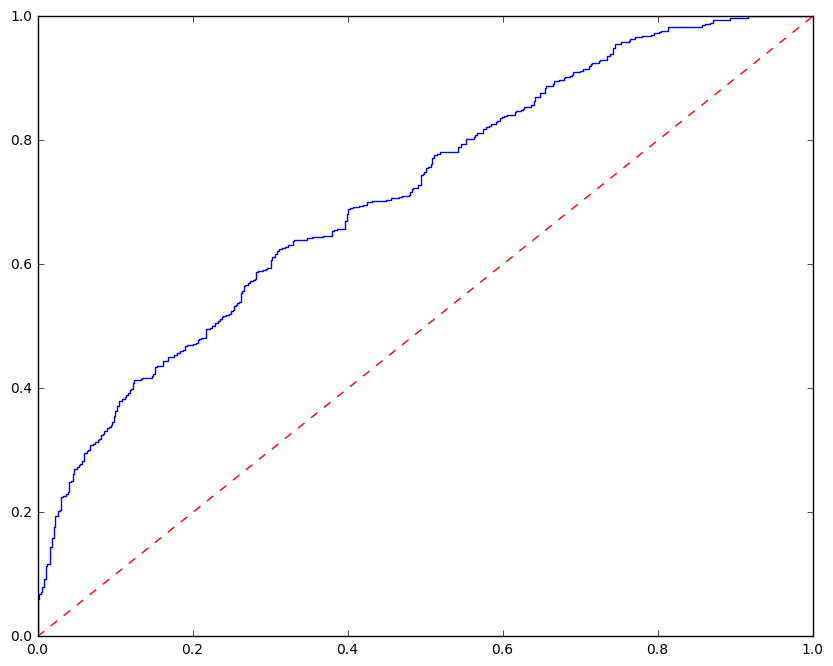

In [28]:
a,b,_ = roc_curve(tte, y)
plot(a, b)
plot([0,1],[0,1],"r--")

# Nonlinear SVM

Finally, using your `lsvm` code as a basis, write a new function to implement a fully nonlinear SVM with a user-specfied kernel function.   Your code should have the signature:

    sv, score = svm(X, t, C, kernel, Xtest)
    
where the `X`, `t`, `C` and `Xtest` are as before and `kernel` is a function that evaluates a kernel and can be called by your svm to evaluate the similarity of any pair of vectors:

    ip = kernel(x, y)     # inner product in some high-dimensional space

For example, the following cell implements an RBF kernel function

In [42]:
def rbf(x, y, gamma=1):
    """RBF kernel with precision gamma."""
    d = x-y
    return exp(-gamma*dot(d, d))

In [43]:
def polynomialKernel(x, y, r=1):
    return (1 + dot(x,y))**r

In [56]:
def svm(Xtr, ttr, Xte, tte = None, kernel = rbf, C = None ):
    
    N = len(Xtr)

    K = ones((N,N))
    for i in range(N):
        for j in range(N):
            K[i][j] = kernel(Xtr[i], Xtr[j])
    
    # Initialise parameters
    P = matrix(outer(ttr,ttr) * K)
    q = matrix(ones(N) * -1)

    if C is None:
        G = matrix(diag(ones(N) * -1))
        h = matrix(zeros(N))
    else:
        tmp1 = diag(ones(N) * -1)
        tmp2 = identity(N)
        G = matrix(vstack((tmp1, tmp2)))
        tmp1 = zeros(N)
        tmp2 = ones(N) * C
        h = matrix(hstack((tmp1, tmp2)))

    A = matrix(ttr, (1,N))
    b = matrix(0.0)

    solution = solvers.qp(P, q, G, h, A, b)
    alpha=solution['x']
    
    # Identify the support vector indexes
    SupportVectors = [ i for i,v in enumerate(alpha) if v > 0.00001 ]
    
    # Construct the bias vector
    bias = take(ttr,SupportVectors)
    for i, svI in enumerate(SupportVectors):
        for j, svJ in enumerate(SupportVectors):
            bias[i] -= alpha[svJ]*ttr[svJ]*kernel(Xtr[svI], Xtr[svJ])
        
    # Calculate the values of Y
    Y = []
    for i, point in enumerate(Xte):
        Y.append(mean(bias) + sum([alpha[j]*ttr[j]*kernel(Xtr[j], point) for j in SupportVectors]))
    

    if tte is not None:
        a = sign(Y)
        return sum( ones(tte.shape)[tte != a])/len(tte)
    
    return Y, [append(Xtr[i], array([ttr[i]])) for i in SupportVectors]

Test your code on the non-separable data above using a linear kernel, the RBF kernel and the polynomial kernel.  You will need to use cross-validation to choose the best parameters and it is fine to use the `scikit` cross validation and grid search machinery rather than writing your own.

//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Estimated value of C: 2.32995181052e+13


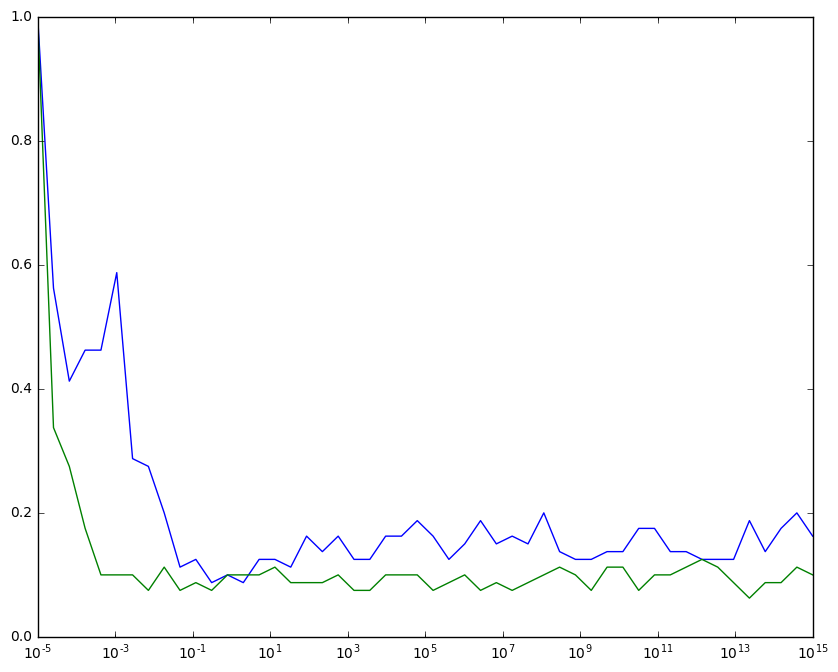

In [54]:
Xtr, ttr, Xte, tte = unseparableData()
kernels, C = [rbf, polynomialKernel], logspace(-5, 15, 50)
meanScores, _ = cv(svm, Xtr, ttr, [kernels, C])

if min(meanScores[0]) < min(meanScores[1]):
    Cestimate = C[meanScores[0].index(min(meanScores[0]))]
else:
    Cestimate = C[meanScores[1].index(min(meanScores[1]))]

print("Estimated value of C:", Cestimate)

plot(C,meanScores[0])
plot(C,meanScores[1])
xscale("log")

## gmm5 data

Demonstate your code on the `gmm5` data with a (useful!) kernel of your choice.  As in the lecture slides, make contour plots of the distance from the separating hyperplane.  What is the accuracy of the classifier?

Accuracy value for best:  0.653


True

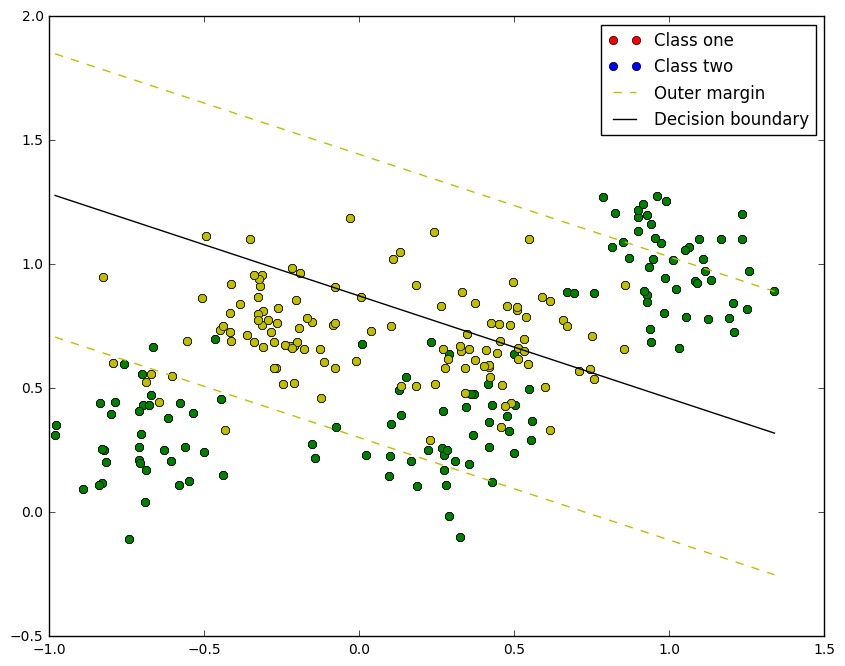

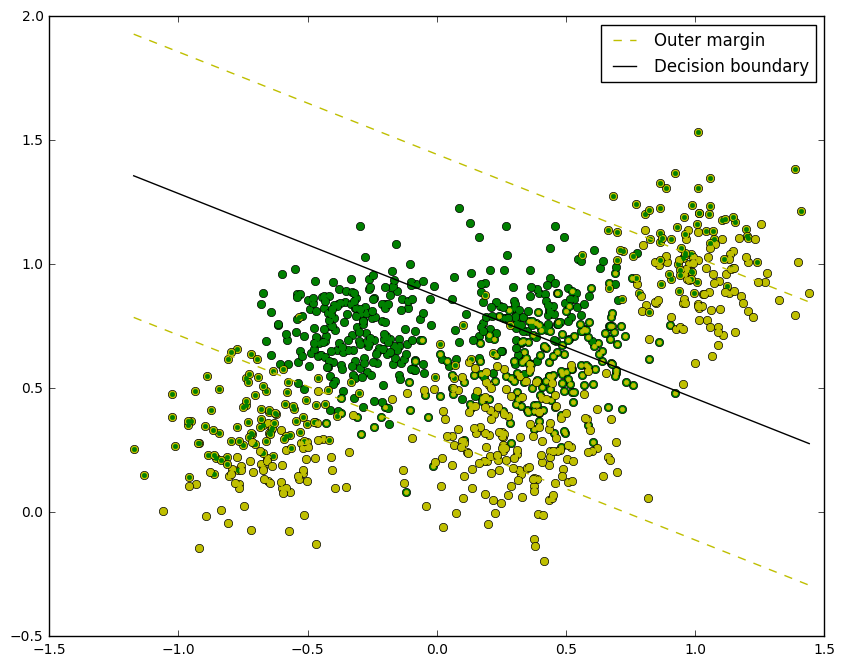

In [71]:
Xtr, ttr, Xte, tte = gmm5Data()
Y, sv = svm(Xtr, ttr, Xte, kernel=polynomialKernel, C=Cestimate)
graph(Xtr,ttr,Xte,tte,Y, sv)

print("Accuracy value for best: ", 1 - svm(Xtr, ttr, Xte, tte, kernel=polynomialKernel, C=Cestimate))

"""
figure()
graph(Xtr,ttr)
#pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

X1, X2 = np.meshgrid(np.linspace(-6,6,len(ttr)), np.linspace(-6,6,len(ttr)))
#X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
#Y = [polynomialKernel(x, y) for x, y in X]
array(Y).reshape(X1)
contour(X1, X2, array(Y).reshape(X1), [0.0], colors='k', linewidths=1, origin='lower')
contour(X1, X2, array(Y).reshape(X1) + 1, [0.0], colors='grey', linewidths=1, origin='lower')
contour(X1, X2, array(Y).reshape(X1) - 1, [0.0], colors='grey', linewidths=1, origin='lower')
"""

1 == 1

# ROC curves

Using the (signed) distance from the separating hyperplane in the SVM as the score, plot the ROC curve for the GMM5 data.  It would be good to plot the ROC curve for the kernelised SVM on the same plot as your linear SVM that you found above.


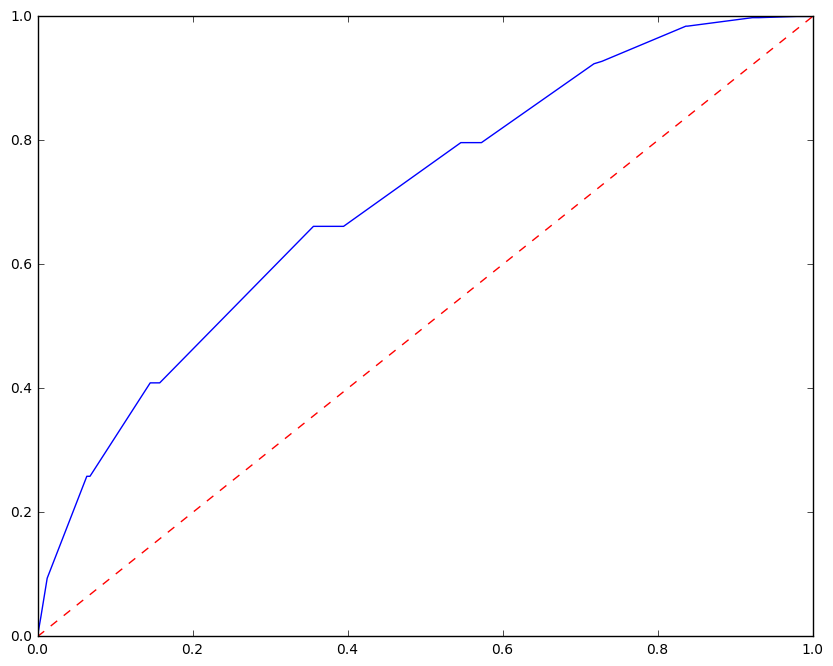

In [73]:
a, b, _ = roc_curve(tte, Y)
plot(a, b)
plot([0,1],[0,1],"r--")